In [31]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import os
from PIL import Image
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
from torchvision.transforms import transforms, Compose, ToTensor, Resize, Normalize, CenterCrop
from torch import nn
from tqdm import tqdm
from torchinfo import summary
import numpy as np
import math


In [32]:
class SnakeDataSet(Dataset):
    def __init__(self, dataframe, root_dir, stack_size, transform = None):
        self.stack_size = stack_size
        self.key_frame = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_frame) - self.stack_size *3

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
        try:
            img_names = [os.path.join(self.root_dir, self.key_frame.iloc[idx + i, 0]) for i in range(self.stack_size)]
            images = [Image.open(img_name) for img_name in img_names]
            label = torch.tensor(self.key_frame.iloc[idx + self.stack_size, 1])
            if self.transform:
                images = [self.transform(image) for image in images]
        except:
            img_names = [os.path.join(self.root_dir, self.key_frame.iloc[0 + i, 0]) for i in range(self.stack_size)]
            images = [Image.open(img_name) for img_name in img_names]
            label = torch.tensor(self.key_frame.iloc[0 + self.stack_size, 1])
            if self.transform:
                images = [self.transform(image) for image in images]
        return torch.stack(images), label

In [33]:
transformer = Compose([
    Resize((64,64), antialias=True),
    CenterCrop(64),
    ToTensor(),
    Normalize(mean =[0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225] )
])

In [34]:
STACK_SIZE = 4


train, test = train_test_split(pd.read_csv("data/labels_snake.csv"), test_size=0.1, shuffle=False)
classes = ["n", "left", "up", "right", "down"]

labels_unique, counts = np.unique(train["class"], return_counts=True)
class_weights = [sum(counts)/c for c in counts]
example_weights = np.array([class_weights[l] for l in train['class']])
example_weights = np.roll(example_weights, -STACK_SIZE)
sampler = WeightedRandomSampler(example_weights, len(train))

labels_unique, counts = np.unique(test["class"], return_counts=True)
class_weights = [sum(counts)/c for c in counts]
test_example_weights = np.array([class_weights[l] for l in test['class']])
test_example_weights = np.roll(test_example_weights, -STACK_SIZE)
test_sampler = WeightedRandomSampler(test_example_weights, len(test))


In [35]:
from torch.utils.data import DataLoader
BATCH_SIZE = 128
dataset = SnakeDataSet(root_dir="captures", dataframe = train, stack_size=STACK_SIZE, transform=transformer)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler, drop_last= True)
test_dataset = SnakeDataSet(root_dir="captures", dataframe = test, stack_size=STACK_SIZE,  transform=transformer)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler = test_sampler, drop_last=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([3, 1, 4, 4, 2, 4, 1, 1, 2, 3, 0, 3, 1, 0, 0, 2, 3, 0, 4, 2, 2, 1, 3, 1,
        2, 0, 4, 1, 4, 2, 3, 2, 4, 2, 0, 0, 4, 0, 1, 3, 4, 2, 1, 0, 4, 4, 0, 4,
        4, 0, 3, 3, 4, 2, 0, 3, 0, 0, 2, 0, 2, 3, 4, 0, 4, 1, 4, 4, 1, 4, 2, 1,
        4, 4, 0, 1, 0, 0, 4, 3, 3, 4, 0, 2, 1, 0, 3, 0, 4, 0, 4, 3, 4, 1, 4, 4,
        1, 2, 3, 2, 1, 2, 0, 0, 0, 4, 3, 2, 0, 1, 4, 3, 2, 3, 0, 2, 2, 3, 4, 1,
        1, 0, 0, 1, 0, 1, 4, 4])


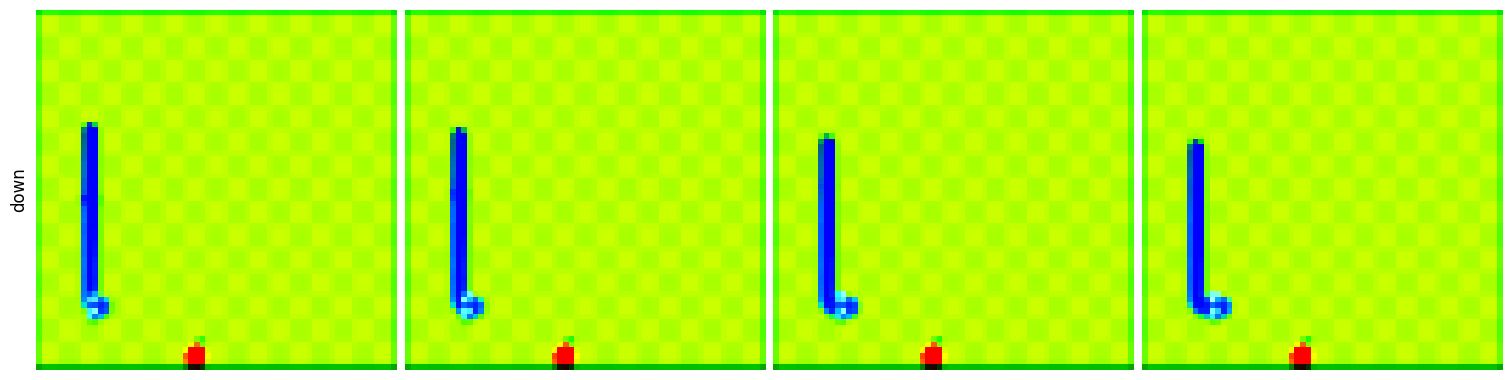

In [36]:
images, label = next(iter(dataloader))
print(label)
from matplotlib.pyplot import subplots
fig,ax = subplots(1, STACK_SIZE, constrained_layout = True, figsize=(15,5))
for i in range(STACK_SIZE):
    ax[i].imshow(images[2][i].permute(1,2,0));
    ax[i].axis('off')
fig.supylabel(classes[label[2].item()]);

In [37]:
class PositionalEncoder(nn.Module):
    """
    The authors of the original transformer paper describe very succinctly what
    the positional encoding layer does and why it is needed:

    "Since our model contains no recurrence and no convolution, in order for the
    model to make use of the order of the sequence, we must inject some
    information about the relative or absolute position of the tokens in the
    sequence." (Vaswani et al, 2017)
    Adapted from:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(
        self,
        dropout: float=0.1,
        max_seq_len: int=5000,
        d_model: int=512,
        batch_first: bool=False
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model
                     (Vaswani et al, 2017)
        """

        super().__init__()

        self.d_model = d_model

        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first

        # adapted from PyTorch tutorial
        position = torch.arange(max_seq_len).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        if self.batch_first:
            pe = torch.zeros(1, max_seq_len, d_model)

            pe[0, :, 0::2] = torch.sin(position * div_term)

            pe[0, :, 1::2] = torch.cos(position * div_term)
        else:
            pe = torch.zeros(max_seq_len, 1, d_model)

            pe[:, 0, 0::2] = torch.sin(position * div_term)

            pe[:, 0, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or
               [enc_seq_len, batch_size, dim_val]
        """
        if self.batch_first:
            x = x + self.pe[:,:x.size(1)]
        else:
            x = x + self.pe[:x.size(0)]

        return self.dropout(x)

In [38]:
class SnakeConvolver(nn.Module):
    def __init__(self, in_channels, stack_size, kernel_size, stride, hidden_channels = 128):
        super(SnakeConvolver,self).__init__()
        self.in_channels = in_channels
        self.stack_size = stack_size
        self.hidden_channels = hidden_channels

        self.convblock = nn.Sequential(
            nn.Conv2d(in_channels, self.hidden_channels, kernel_size, stride),
            nn.MaxPool2d(kernel_size, kernel_size),
            nn.BatchNorm2d(self.hidden_channels),
            nn.ReLU(),
            nn.Conv2d(self.hidden_channels, self.hidden_channels*2, kernel_size, stride),
            nn.MaxPool2d(kernel_size, kernel_size),
            nn.BatchNorm2d(self.hidden_channels*2),
            nn.ReLU(),
        )
        self.positionencoder = PositionalEncoder(d_model = self.hidden_channels*2, max_seq_len=self.stack_size+1, batch_first=True)
        self.class_token_embeddings = nn.Parameter(torch.rand((BATCH_SIZE, 1, hidden_channels*2), requires_grad=True))

    def forward(self,x):
        embeds = torch.stack([self.convblock(x[:,i,:,:,:]) for i in range(self.stack_size)],dim=1).squeeze()
        out = torch.cat((self.class_token_embeddings,embeds),dim=1)
        out = self.positionencoder(out)
        return out

In [39]:
class SnakeMSA(nn.Module):
    def __init__(self, embed_dims, num_heads, dropout = 0.5):
        super(SnakeMSA, self).__init__()
        self.embed_dims = embed_dims
        self.num_heads = num_heads
        self.layernorm = nn.LayerNorm(normalized_shape = self.embed_dims)
        self.attentionblock = nn.MultiheadAttention(embed_dims, num_heads, dropout=dropout, batch_first=True)
    def forward(self, x):
        x = self.layernorm(x)
        x = self.attentionblock(x, x, x, need_weights = False)[0]
        return x

In [40]:
class MLP(nn.Module):
    def __init__(self, embed_dims, hidden_units, dropout = 0.3):
        super(MLP, self).__init__()
        self.embed_dims = embed_dims
        self.hidden_units = hidden_units
        self.layernorm = nn.LayerNorm(embed_dims)
        self.mlp = nn.Sequential(
                                        nn.Linear(self.embed_dims,self.hidden_units), 
                                        nn.GELU(),
                                        nn.Dropout(dropout),
                                        nn.Linear(self.hidden_units, self.embed_dims),
                                        nn.Dropout(dropout),                                      
                                        )

    def forward(self, x):
        return self.mlp(self.layernorm(x))

In [41]:
class SnakeTransformer(nn.Module):
    def __init__(self, embed_dims, num_heads, hidden_units=256, msa_dropout=0.5, mlp_dropout=0.3):
        super().__init__()
        self.embed_dims = embed_dims
        self.num_heads = num_heads
        self.msa_dropout = msa_dropout
        self.mlp_dropout = mlp_dropout
        self.hidden_units = hidden_units
        self.msa = SnakeMSA(embed_dims, num_heads, msa_dropout)
        self.mlp = MLP(embed_dims, hidden_units, mlp_dropout)

    def forward(self, x):
        x = self.msa(x) + x
        x = self.mlp(x) + x
        return x

In [42]:
class SnakeModel(nn.Module):
    def __init__(self, 
                 in_channels=3, 
                 stack_size = STACK_SIZE,
                 kernel_size =3, 
                 stride=2, 
                 embed_dims = 768, 
                 num_transformer_blocks = 12,  
                 num_heads = 12, 
                 msa_dropout = 0.0, 
                 mlp_dropout = 0.1, 
                 hidden_channels = 384,
                 hidden_units=3072, 
                 output_size=5):
        super(SnakeModel, self).__init__()
        self.stack_size = stack_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.embed_dims = embed_dims
        self.num_heads = num_heads
        self.msa_dropout = msa_dropout
        self.hidden_channels = hidden_channels
        self.hidden_units = hidden_units
        self.output_size = output_size
        self.in_channels = in_channels
        self.mlp_dropout = mlp_dropout
        self.num_transformer_blocks = num_transformer_blocks
        self.encoder = SnakeConvolver(in_channels, stack_size, kernel_size, stride, hidden_channels=  self.hidden_channels)
        self.transformer = nn.Sequential(*[SnakeTransformer(self.embed_dims, 
                                                            self.num_heads, 
                                                            self.hidden_units,
                                                            self.msa_dropout,
                                                            self.mlp_dropout,
                                                            ) for _ in range(self.num_transformer_blocks)])
        self.classifier = nn.Sequential(nn.LayerNorm(embed_dims),
                                        nn.Linear(embed_dims, output_size))
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(self.transformer(x)[:,0])
        return x

In [44]:
images.shape

torch.Size([128, 4, 3, 64, 64])

In [45]:
model = SnakeModel()
summary(model, (BATCH_SIZE,STACK_SIZE,3, 64,64), depth=5)


Layer (type:depth-idx)                        Output Shape              Param #
SnakeModel                                    [128, 5]                  --
├─SnakeConvolver: 1-1                         [128, 5, 768]             98,304
│    └─Sequential: 2-1                        [128, 768, 1, 1]          --
│    │    └─Conv2d: 3-1                       [128, 384, 31, 31]        10,752
│    │    └─MaxPool2d: 3-2                    [128, 384, 10, 10]        --
│    │    └─BatchNorm2d: 3-3                  [128, 384, 10, 10]        768
│    │    └─ReLU: 3-4                         [128, 384, 10, 10]        --
│    │    └─Conv2d: 3-5                       [128, 768, 4, 4]          2,654,976
│    │    └─MaxPool2d: 3-6                    [128, 768, 1, 1]          --
│    │    └─BatchNorm2d: 3-7                  [128, 768, 1, 1]          1,536
│    │    └─ReLU: 3-8                         [128, 768, 1, 1]          --
│    └─Sequential: 2-2                        [128, 768, 1, 1]          (rec

In [46]:
from torch.optim.lr_scheduler import LinearLR
num_epochs = 7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(model.parameters(), 10e-6, weight_decay=0.1,)
scheduler = LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=num_epochs)
model.to(device)
criterion = nn.CrossEntropyLoss()



In [47]:
model(images.to(device)).shape

torch.Size([128, 5])

In [48]:
steps = 0
for epoch in range(num_epochs):
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    val_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    # Set model to training mode
    model.train()

    # tqdm bar for progress visualization
    pbar = tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=True)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update statistics
        total_loss += loss.item()
        _, predicted = torch.max(torch.softmax(outputs,1), 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Update tqdm bar with current loss and accuracy
        pbar.set_postfix({'Loss': total_loss / total_samples, 'Accuracy': correct_predictions / total_samples})
        steps = steps + 1
        # if steps>1000:
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] = 2e-5

    model.eval()
    with torch.inference_mode():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels)

            # Update statistics
            val_loss += loss.item()
            _, predicted = torch.max(torch.softmax(outputs,1), 1)
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_samples += labels.size(0)

    # Calculate and print epoch-level accuracy and loss for validation
    epoch_loss = val_loss / val_total_samples
    epoch_accuracy = val_correct_predictions / val_total_samples
    print(f'Epoch {epoch + 1}/{num_epochs}, Val Loss: {epoch_loss:.4f}, Val Accuracy: {epoch_accuracy:.4f}')

Epoch 1/7: 100%|██████████| 1098/1098 [34:39<00:00,  1.89s/it, Loss=0.00761, Accuracy=0.605]


Epoch 1/7, Val Loss: 0.0117, Val Accuracy: 0.5039


Epoch 2/7: 100%|██████████| 1098/1098 [33:29<00:00,  1.83s/it, Loss=0.0055, Accuracy=0.718] 


Epoch 2/7, Val Loss: 0.0132, Val Accuracy: 0.4963


Epoch 3/7:  45%|████▌     | 496/1098 [15:22<18:39,  1.86s/it, Loss=0.0049, Accuracy=0.75]  


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "weights.pth")


In [ ]:
criterion = nn.CrossEntropyLoss()
total_loss = 0.0
correct_predictions = 0
total_samples = 0

with torch.inference_mode():
  # Set model to training mode
  model.eval()

  # tqdm bar for progress visualization
  pbar = tqdm(test_dataloader, leave=True)

  with torch.inference_mode(): 
    
    for inputs, labels in pbar:
        # Forward pass
        inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels)

        # Update statistics
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Update tqdm bar with current loss and accuracy
        pbar.set_postfix({'Loss': total_loss / total_samples, 'Accuracy': correct_predictions / total_samples})

    # Calculate and print epoch-level accuracy and loss
    epoch_loss = total_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

100%|██████████| 125/125 [00:49<00:00,  2.54it/s, Loss=0.175, Accuracy=0.35] 

Epoch 20/20, Loss: 0.1752, Accuracy: 0.3505


In [ ]:
images, label = next(iter(dataloader))
model(images.to(device))

tensor([[ 1.8871,  5.5179,  0.0093, -6.6027, -0.3690],
        [ 0.4526, -5.7828, -0.3614,  4.9467, -0.7812],
        [ 3.1903,  5.2011,  0.3370, -7.4490, -1.9668],
        [ 0.3016, -2.6541,  2.7760,  2.0058, -3.3939],
        [ 1.0856, -7.8013, -0.5289,  6.2668, -1.5776],
        [ 3.0884, -2.2665, -6.6093, -0.0931,  4.0961],
        [ 0.4661, -7.0749, -2.2711,  6.2445,  0.9774],
        [ 3.7324,  1.8034, -5.9827, -4.3991,  3.6110],
        [ 1.7292, -6.6276, -3.5998,  4.8401,  1.3216],
        [ 3.2603,  1.6302, -6.6735, -3.7937,  4.7435],
        [ 4.2501,  1.9277, -4.3518, -5.0623,  1.4290],
        [ 2.0982,  4.6273,  2.6636, -6.1395, -3.5514],
        [ 1.4905, -0.5644,  4.0618, -0.9971, -5.4521],
        [ 0.6972,  1.3567, -4.2940, -1.5220,  4.5105],
        [ 1.4132,  1.1621, -4.2883, -1.9620,  3.8141],
        [ 1.9964, -7.1878, -0.9924,  4.9488, -1.7965]], device='cuda:0',
       grad_fn=<AddmmBackward0>)